In [2]:
import pandas as pd
df=pd.read_csv("top_30_corr.csv")
df.shape

(905832, 111)

In [1]:
# 💾 Script LightGBM para predecir tn en febrero 2020

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datos
df = pd.read_csv("top_30_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)

# 4. Agregar variable mes
df_lags['mes'] = df_lags['periodo'].dt.month

# 5. Eliminar filas con NaN por los lags
df_train = df_lags.dropna()

# 6. Separar features y target
# Usá todas excepto tn, periodo y product_id
features = [col for col in df_train.columns if col not in ['tn', 'periodo', 'product_id']]
#features = ['lag_1', 'lag_2', 'lag_3', 'mes']
target = 'tn'

# 7. Separar train y validación
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

# 8. Hiperparámetros de Optuna
mejores_params = {
   'n_estimators': 774,
    'learning_rate': 0.013833513325596666,
    'max_depth': 10,
    'num_leaves': 183,
    'subsample': 0.7698019331794512,
    'colsample_bytree': 0.7228716766181406,
    'random_state': 42,
    'min_data_in_leaf': 320,
    'reg_alpha': 0.5095229446241581,
    'reg_lambda': 1.616069961165865,
    'linear_tree': True
}

modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 9. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 10. Predicción enero 2020
enero_df = df_prod[df_prod['periodo'] == '2019-12-01'].copy()
enero_df['periodo'] = pd.to_datetime('2020-01-01')
enero_df['lag_1'] = df_prod[df_prod['periodo'] == '2019-12-01']['tn'].values
enero_df['lag_2'] = df_prod[df_prod['periodo'] == '2019-11-01']['tn'].values
enero_df['lag_3'] = df_prod[df_prod['periodo'] == '2019-10-01']['tn'].values
enero_df['mes'] = 1
enero_df['tn'] = modelo.predict(enero_df[features])

# 11. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = enero_df['product_id']
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['lag_1'] = enero_df['tn']  # predicción enero
feb_df['lag_2'] = df_prod[df_prod['periodo'] == '2019-12-01']['tn'].values
feb_df['lag_3'] = df_prod[df_prod['periodo'] == '2019-11-01']['tn'].values
feb_df['mes'] = 2
feb_df['tn_predicho'] = modelo.predict(feb_df[features])

# 12. Exportar resultados
resultado = feb_df[['product_id', 'tn_predicho']]
resultado.to_csv("prediccion_feb2020_top304.csv", index=False)
print("✅ Predicción de febrero 2020 guardada en prediccion_feb2020_top304.csv")


[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 4
[LightGBM] [Info] Start training from score 157.574272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [2]:
import pandas as pd

# 1. Cargar predicciones de Autogluon (febrero 2020)
df_pred = pd.read_csv("prediccion_feb2020_top304.csv")  # asumimos que tiene 'product_id' y 'tn_predicha'
total_predicho = df_pred["tn_predicho"].sum()

# 2. Cargar dataset base
df_real = pd.read_csv("top_40_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar toneladas reales por período
tn_por_periodo = df_real.groupby("periodo")["tn"].sum().reset_index()

# 4. Agregar predicción de febrero 2020 como nueva fila
nueva_fila = pd.DataFrame({"periodo": [pd.Timestamp("2020-02-01")], "tn": [total_predicho]})
comparacion = pd.concat([tn_por_periodo, nueva_fila], ignore_index=True)

# 5. Ordenar por período
comparacion = comparacion.sort_values("periodo")

# 6. Mostrar
print(comparacion.tail(6))  # últimas filas para ver cómo se compara febrero 2020


      periodo            tn
31 2019-08-01   8142.772430
32 2019-09-01  12112.214620
33 2019-10-01  13491.000060
34 2019-11-01  11420.581260
35 2019-12-01   9960.630910
36 2020-02-01   8221.009518


In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datos
df = pd.read_csv("top_30_corr.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Crear lags sin perder features
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df)

# 3. Agregar variable mes
df_lags['mes'] = df_lags['periodo'].dt.month

# 4. Eliminar filas con NaN por los lags
df_train = df_lags.dropna()

# 5. Separar features y target
features = [col for col in df_train.columns if col not in ['tn', 'periodo', 'product_id']]
target = 'tn'

# 6. Separar train y validación
train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

print("🧠 Entrenando con", len(features), "features:", features)

# 7. Hiperparámetros de Optuna
mejores_params = {
    'n_estimators': 774,
    'learning_rate': 0.013833513325596666,
    'max_depth': 10,
    'num_leaves': 183,
    'subsample': 0.7698019331794512,
    'colsample_bytree': 0.7228716766181406,
    'random_state': 42,
    'min_data_in_leaf': 320,
    'reg_alpha': 0.5095229446241581,
    'reg_lambda': 1.616069961165865,
    'linear_tree': True
}

modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 8. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 9. Predicción enero 2020
enero_df = df_lags[df_lags['periodo'] == '2019-12-01'].copy()
enero_df['periodo'] = pd.to_datetime('2020-01-01')
enero_df['lag_1'] = df_lags[df_lags['periodo'] == '2019-12-01']['tn'].values
enero_df['lag_2'] = df_lags[df_lags['periodo'] == '2019-11-01']['tn'].values
enero_df['lag_3'] = df_lags[df_lags['periodo'] == '2019-10-01']['tn'].values
enero_df['mes'] = 1

# Reconstruir features si falta alguna
for col in features:
    if col not in enero_df.columns:
        enero_df[col] = 0

enero_df['tn'] = modelo.predict(enero_df[features])

# 10. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = enero_df['product_id']
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['lag_1'] = enero_df['tn']  # predicción enero
feb_df['lag_2'] = df_lags[df_lags['periodo'] == '2019-12-01']['tn'].values
feb_df['lag_3'] = df_lags[df_lags['periodo'] == '2019-11-01']['tn'].values
feb_df['mes'] = 2

# Copiar columnas adicionales desde enero_df
for col in features:
    if col not in feb_df.columns:
        if col in enero_df.columns:
            feb_df[col] = enero_df[col].values
        else:
            feb_df[col] = 0

feb_df['tn_predicho'] = modelo.predict(feb_df[features])

# 11. Exportar resultados
resultado = feb_df[['product_id', 'tn_predicho']]
resultado.to_csv("prediccion_feb2020_top305.csv", index=False)
print("✅ Predicción de febrero 2020 guardada en prediccion_feb2020_top305.csv")


🧠 Entrenando con 108 features: ['customer_id', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'stock_final', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'tn_norm', 'cust_request_tn_norm', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'delta_lag_1', 'delta_lag_2', 'delta_lag_3', 'delta_lag_4', 'delta_lag_5', 'delta_lag_6', 'delta_lag_7', 'delta_lag_8', 'delta_lag_9', 'delta_lag_10', 'delta_lag_11', 'delta_lag_12', 'delta_lag_13', 'delta_lag_14', 'delta_lag_15', 'delta_lag_16', 'delta_lag_17', 'delta_lag_18', 'delta_lag_19', 'delta_lag_20', 'delta_lag_21', 'delta_lag_22', 'delta_lag_23', 'delta_lag_24', 'delta_lag_25', 'delta_lag_26', 'delta_lag_27', 'delta_lag_28', 'del

C:\Users\waldo\AppData\Local\Temp\ipykernel_19844\1170640827.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feb_df[col] = enero_df[col].values
C:\Users\waldo\AppData\Local\Temp\ipykernel_19844\1170640827.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feb_df[col] = enero_df[col].values
C:\Users\waldo\AppData\Local\Temp\ipykernel_19844\1170640827.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
✅ Predicción de febrero 2020 guardada en prediccion_feb2020_top305.csv


C:\Users\waldo\AppData\Local\Temp\ipykernel_19844\1170640827.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feb_df['tn_predicho'] = modelo.predict(feb_df[features])


In [6]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_top305.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("top_30_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(12))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo          tn
25 2019-02-01  8200.43425
26 2019-03-01  9807.17781
27 2019-04-01  9250.80390
28 2019-05-01  8810.16406
29 2019-06-01  8990.23955
30 2019-07-01  8686.82434
31 2019-08-01  6763.95623
32 2019-09-01  9211.42458
33 2019-10-01  9392.19592
34 2019-11-01  9015.62816
35 2019-12-01  6586.56535
36 2020-02-01  2164.67800



📌 Importancia de variables:
                 feature  importancia
3        cust_request_tn        16517
83             tn_mean_3        10225
11  cust_request_tn_norm         7453
84              tn_std_3         6965
10               tn_norm         6391
86              tn_std_6         3085
48           delta_lag_1         2670
7                   cat3         2609
9               sku_size         2560
12                 lag_1         2376


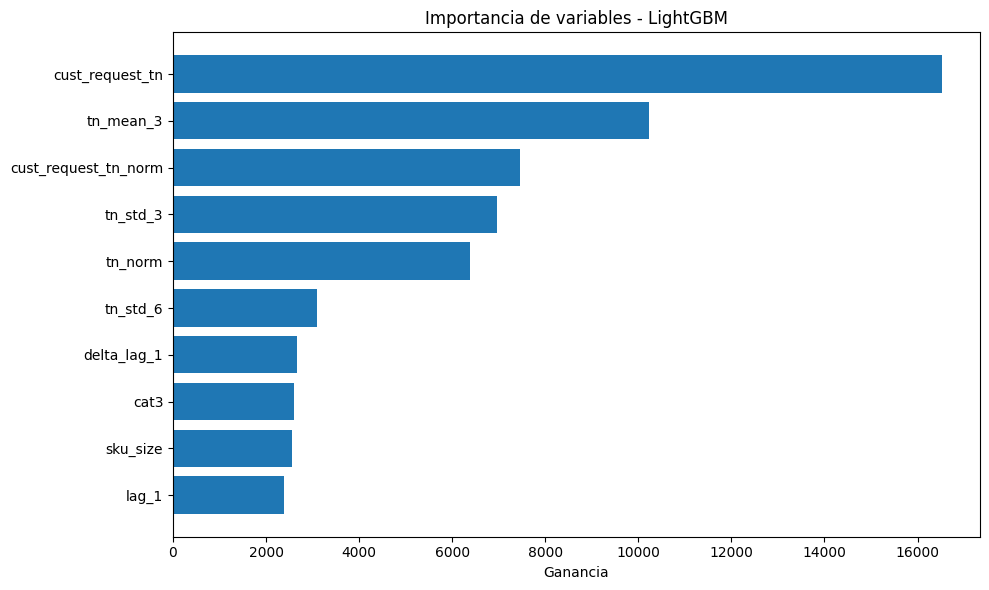

In [8]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()
